In [1]:
!pip install plotly
!pip install psycopg2
!pip install sqlalchemy
!pip install -U kaleido

In [2]:
import plotly.express as px
import pandas as pd
import psycopg2
import os
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import text
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

# 1 -Connect to the database

- Embed the credentials.
- Run the engine and create SQL commands to query the database. 
<hr>

In [3]:
redshift_endpoint = os.getenv('db_host')
redshift_user = os.getenv('db_user')
redshift_pass = os.getenv('db_password')
port = os.getenv('db_port')
dbname = os.getenv('db_name')

In [4]:
engine_string = f"postgresql+psycopg2://{redshift_user}:{redshift_pass}@{redshift_endpoint}:{port}/{dbname}"
engine = create_engine(engine_string)

# 2 - Lay out expectations

Want to know:
- How I tackle the problem
- Succinct communication of findings
- See the workings (SQL queries etc)

I use python notebooks and DBeaver to query the database, although for readability I have left the sql queries within this notebook.

<hr>



### Are some segments of DICE fans retained better than others?

1. Define retention. We are working with an app so keep this in mind. 

2. Do you see any differences between groups/cohorts??

3. What other segments/data would you like to look into if you had more?

        - Gender, income, marital status, occupation
        - More granular location? As customers move?
        - Languages spoken, interests, personality traits
        - Social media data - to understand the motivation behind users and perhaps some kind of virality sharing metric.

<hr>
What we know about the data:
 
- __transactions__ gives data on the transaction that represents a fan’s __first__ purchase on DICE.
Note that __later transactions for the same users are not included.__
- __users__ gives some basic information about the fans registered with DICE.
- __events__ gives some top-level information on the events (gigs) listed on DICE.
- __event_genres__ gives a third level of classification (after event_type and event_category)
above.
- __user_activity__ is a daily record of activity for each user in the users table from 1 January 2019
or the date they registered, whichever is latest, to 31 December 2019. These are activities
occurring on the date shown, not a __cumulative total__. Users appear in this table every day after
they registered regardless of whether any activity was recorded

# 3 - Plan of attack

How to tackle the problem:

1. Familiarise myself with the dataset first.
    - What is the schema?
    - Number of rows and variables.
    - What are the keys and relationships?
    - What are the key stats from each table?
2. Define retention and look at the retention rate over time.
    - Create a cohort for the users first transactions in January and February respectively. 
3. Do some exploratary data analysis to look into which segmentation to look into. 
    - Look at age, genre, location and app type used. 
4. Create graphs looking at the retention of with these factors. 
5. Conclude/Think of next steps. 


<img src="ERD.jpg" width=1280 height=720 />

<hr>

#### Definition of retention
> We define retention as "the __percentage of users__ who continue __engaging__ with an app __over time__." 

> Retention – The level of engagement a customer has with the DICE app over time. 

We'll use the user_activity table to measure engagement. Any row that does not contain only zeros, will be classed as 'engagement'.

This boils down to:
 $\dfrac{number \: of \: active \: users \: over \: time}{number\: of \: users \:over \:time}$  

__An 'active user' or 'engagement' will be a user which has non-empty rows from the user_activity table.__

<hr>


# 5 - Retention rate over time. 
- Create January and February Cohorts of users and measure there engagement over time 

In [5]:
sql1= """
with jan_cohort as (
    select t.user_id as user_id
from analyst_task.transactions t 
    where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
),
new_customers as (
    select count(user_id) as jan_new_customers
    from jan_cohort
),
revisit as (
select 
    date_part('year', ua."date") as yr,
    date_part('month', ua."date") as mth,
    count (distinct ua.user_id) as num_engaged_users,
    count (ua.user_id) as num_interactions
from analyst_task.user_activity ua 
inner join jan_cohort on jan_cohort.user_id = ua.user_id 
    where yr=2019
    and greatest(count_events_viewed, count_events_saved, count_tickets_purchased, count_tickets_purchased_mobile, count_tickets_purchased_web, count_mobile_sessions, count_web_sessions, count_waitinglists_joined) >= 1
    group by yr, mth
)
select *
from revisit, new_customers
order by revisit.mth;
"""
df_jan_cohort = pd.read_sql_query(text(sql1), engine)


In [6]:
# Create the percentage engagement by dividing the number of engaged users by total users that month
df_jan_cohort['%_engagement'] = round(df_jan_cohort['num_engaged_users']/df_jan_cohort['jan_new_customers'] * 100, 2)
# interactions per user - divide the number of interactions by the users that are making the interactions 
df_jan_cohort['interactions_per_engaged_user'] = round(df_jan_cohort['num_interactions']/df_jan_cohort['num_engaged_users'], 2)
df_jan_cohort.head(12)

,yr,mth,num_engaged_users,num_interactions,jan_new_customers,%_engagement,interactions_per_engaged_user
0,2019.0,1.0,19547,45111,19558,99.94,2.31
1,2019.0,2.0,9760,26532,19558,49.90,2.72
2,2019.0,3.0,6964,19157,19558,35.61,2.75
3,2019.0,4.0,4971,12465,19558,25.42,2.51
4,2019.0,5.0,4759,13066,19558,24.33,2.75
5,2019.0,6.0,3867,9551,19558,19.77,2.47
6,2019.0,7.0,3459,8612,19558,17.69,2.49
7,2019.0,8.0,3052,7555,19558,15.60,2.48
8,2019.0,9.0,3229,8287,19558,16.51,2.57
9,2019.0,10.0,3336,9484,19558,17.06,2.84


#### Similar query for February

In [7]:
sql2= """
with feb_cohort as (
    select t.user_id as user_id
from analyst_task.transactions t 
    where date_part('month', t.time_stamp) = 2
),
new_customers as (
    select count(user_id) as feb_new_customers
    from feb_cohort
),
revisit as (
select 
    date_part('year', ua."date") as yr,
    date_part('month', ua."date") as mth,
    count (distinct ua.user_id) as num_engaged_users,
    count (ua.user_id) as num_interactions
from analyst_task.user_activity ua 
inner join feb_cohort on feb_cohort.user_id = ua.user_id 
    where yr=2019
    and greatest(count_events_viewed, count_events_saved, count_tickets_purchased, count_tickets_purchased_mobile, count_tickets_purchased_web, count_mobile_sessions, count_web_sessions, count_waitinglists_joined) >= 1
    and mth >= 2
    group by yr, mth

)
select *
from revisit, new_customers
order by revisit.mth;
"""
df_feb_cohort = pd.read_sql_query(text(sql2), engine)


In [8]:
# Create the percentage engagement by dividing the number of engaged users by total users that month
df_feb_cohort['%_engagement'] = round(df_feb_cohort['num_engaged_users']/df_feb_cohort['feb_new_customers'] * 100, 2)
df_feb_cohort['interactions_per_engaged_user'] = round(df_feb_cohort['num_interactions']/df_feb_cohort['num_engaged_users'], 2)

#Transpose the graph by 1 to the left in the x axis
df_feb_cohort['mth'] = df_feb_cohort['mth']-1
df_feb_cohort.head(12)

,yr,mth,num_engaged_users,num_interactions,feb_new_customers,%_engagement,interactions_per_engaged_user
0,2019.0,1.0,23843,55853,23852,99.96,2.34
1,2019.0,2.0,10504,28601,23852,44.04,2.72
2,2019.0,3.0,7105,17340,23852,29.79,2.44
3,2019.0,4.0,6263,16410,23852,26.26,2.62
4,2019.0,5.0,4793,11853,23852,20.09,2.47
5,2019.0,6.0,4261,10482,23852,17.86,2.46
6,2019.0,7.0,3771,9148,23852,15.81,2.43
7,2019.0,8.0,3835,9657,23852,16.08,2.52
8,2019.0,9.0,3906,10962,23852,16.38,2.81
9,2019.0,10.0,3881,10767,23852,16.27,2.77


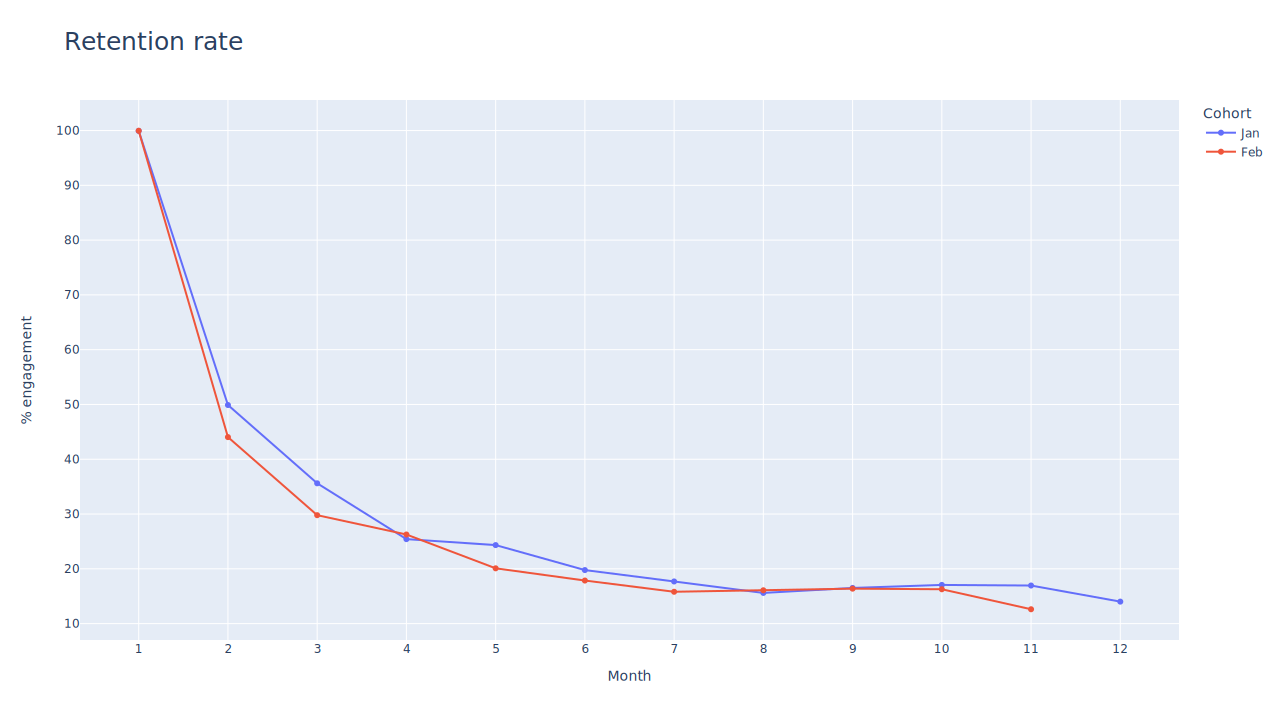

In [9]:
import plotly.graph_objects as go

dfs = {"Jan" : df_jan_cohort, "Feb": df_feb_cohort} # place the two dataframes into a dictionary to loop over them and then plot the points
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]['mth'],
                                   y = dfs[i]['%_engagement'], 

                                   name = i))

#Layout
fig.update_layout(title = "Retention rate", title_font_size=25, legend_title_text = "Cohort")
fig.update_xaxes(title_text='Month', dtick = 1)
fig.update_yaxes(title_text='% engagement')
fig.show(renderer="svg", width=1280, height=720)

<font size="4">
<ul>
    <li>Jan_New_Customers = 19558</li>
    <li>Feb_New_Customers = 23852</li>
</ul>
Increase in adoption of the DICE app month on month. 

<hr>
<br>
The largest drop off in engagement is after one month for both Jan and Feb cohorts.

<ul>
    <li>Jan: 50% drop after one month.</li>
    <li>Feb: 56% drop after one month.</li>
</ul>

<br>
<hr>
After 11 months:
<ul>
    <li>Jan: 17% have been retained (i.e. still engage with the app)</li>
    <li>Feb: 12.6% have been retained (i.e. still engage with the app)</li>
</ul>

    
From this we can see that the <strong>users that bought tickets in January have a higher engagement rate</strong>.
</font>

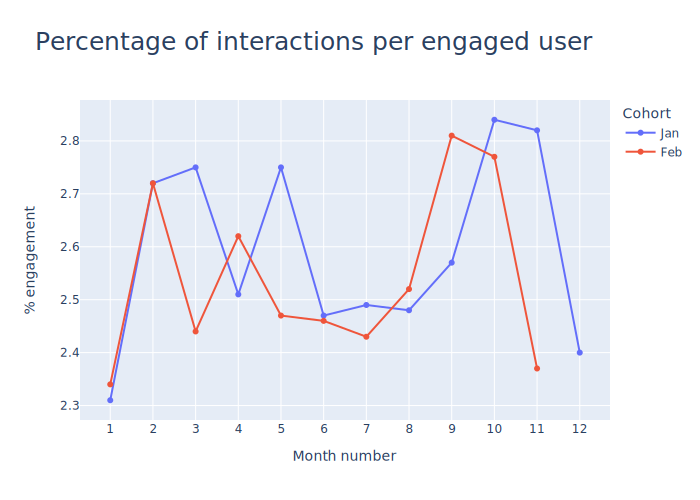

In [10]:
dfs = {"Jan" : df_jan_cohort, "Feb": df_feb_cohort}
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]['mth'],
                                   y = dfs[i]['interactions_per_engaged_user'], 

                                   name = i))
    
fig.update_layout(title = "Percentage of interactions per engaged user", title_font_size=25, legend_title_text = "Cohort")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='% engagement')
fig.show(renderer="svg")

There is a higher number of interactions for the months of September, October and November 2019.

# Look at the Age of the users
1. Age of the January and February cohorts.
2. Look at the age of the users and the engagement with DICE over time.

In [11]:
sql3= """
select
    u.user_id,
    u.date_of_birth,
    current_date
from analyst_task.users u
inner join analyst_task.transactions t
    on u.user_id = t.user_id
    where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
"""
jan_cohort_age = pd.read_sql_query(text(sql3), engine)


In [12]:
# change to pandas series columns to datetime 
jan_cohort_age['date_of_birth'] = pd.to_datetime(jan_cohort_age['date_of_birth'], errors='coerce') 
jan_cohort_age['date'] = pd.to_datetime(jan_cohort_age['date'], errors='coerce')

# subtract todays date from 
jan_cohort_age['age'] = (jan_cohort_age['date'] - jan_cohort_age['date_of_birth']) // np.timedelta64(1, 'Y')

### Place users into age groups 
- Under 18
- 19_to_25
- 26_to_30
- 31_to_40
- 41_to_50
- Over 50

Count the number of users in each age group

In [13]:
jan_cohort_age['age_groups'] = pd.cut(jan_cohort_age['age'], bins=(0,18,25,30,40,50,np.inf), labels=['Under 18','19_to_25','26_to_30','31_to_40','41_to_50','Over 50'])
age_counts = jan_cohort_age['age_groups'].value_counts()
age_counts

26_to_30    5895
31_to_40    5726
19_to_25    4482
41_to_50    1755
Over 50     1121
Under 18      32
Name: age_groups, dtype: int64

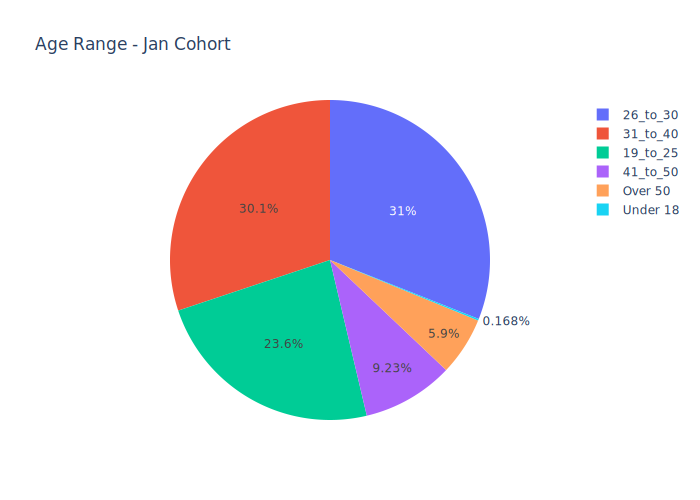

In [14]:
fig = px.pie(jan_cohort_age, values=age_counts, names = age_counts.keys(), title='Age Range - Jan Cohort')
fig.show(renderer="svg")

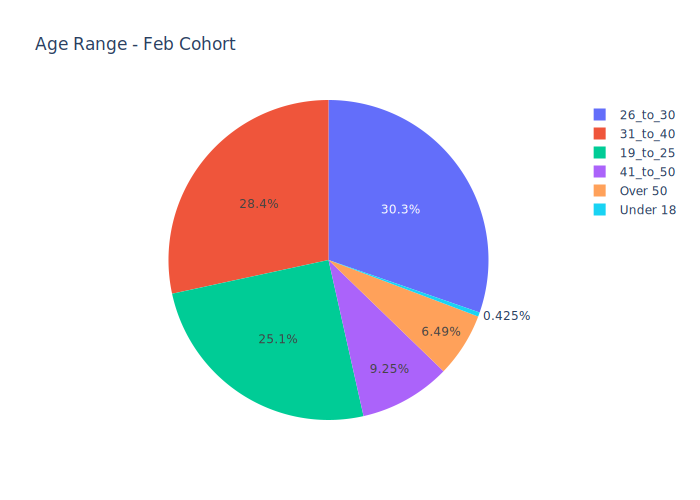

In [15]:
sql4 = """
select
    u.user_id,
    u.date_of_birth,
    current_date
from analyst_task.users u
inner join analyst_task.transactions t
    on u.user_id = t.user_id
    where date_part('month', t.time_stamp) = 2 and date_part('year', t.time_stamp) = 2019
"""
df4 = pd.read_sql_query(text(sql4), engine)
df4['date_of_birth'] = pd.to_datetime(df4['date_of_birth'], errors='coerce')
df4['date'] = pd.to_datetime(df4['date'], errors='coerce')
df4['age'] = (df4['date'] - df4['date_of_birth']) // np.timedelta64(1, 'Y')
df4['age_groups'] = pd.cut(df4['age'], bins=(0,18,25,30,40,50,np.inf), labels=['Under 18','19_to_25','26_to_30','31_to_40','41_to_50','Over 50'])
age_counts_feb = df4['age_groups'].value_counts()

fig = px.pie(df4, values=age_counts_feb, names = age_counts.keys(), title='Age Range - Feb Cohort')
fig.show(renderer="svg")

# January cohort
- purchase_app_type
- genre
- venue type

In [16]:
# query for the new customers in jan and there user ids

sql7 = """
with jan_cohort as (
    select t.user_id as user_id
from analyst_task.transactions t 

where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
),

revisit as (
select 
    ua.user_id,
    date_part('year', ua."date") as yr,
    date_part('month', ua."date") as mth,
    count (distinct ua.user_id) as num_engaged_users,
    count (ua.user_id) as num_interactions
from analyst_task.user_activity ua 
inner join jan_cohort on jan_cohort.user_id = ua.user_id 
    where yr=2019
    and greatest(count_events_viewed, count_events_saved, count_tickets_purchased, count_tickets_purchased_mobile, count_tickets_purchased_web, count_mobile_sessions, count_web_sessions, count_waitinglists_joined) >= 1
    group by yr, mth, ua.user_id
)
select *
from revisit
order by revisit.mth;
"""
jan_co = pd.read_sql_query(text(sql7), engine)

In [17]:
df = pd.merge(jan_co,jan_cohort_age,on='user_id')
df.drop(columns=['date_of_birth', 'date', 'age'], inplace= True)
df.head()

,user_id,yr,mth,num_engaged_users,num_interactions,age_groups
0,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,26_to_30
1,038a75c9ebae7a00dd1f256890baab30,2019.0,1.0,1,2,19_to_25
2,038a75c9ebae7a00dd1f256890baab30,2019.0,3.0,1,1,19_to_25
3,0225a05d5d0f13cb645c7d99bd7086b0,2019.0,1.0,1,1,31_to_40
4,03ff9dbe68ee219d827b6decfc37c667,2019.0,1.0,1,4,19_to_25


In [18]:
grouped = df.groupby(['mth', 'age_groups']).size()
df = grouped.to_frame()
df.rename(columns = {0:'Number_of_users'}, inplace = True)
df.reset_index(level=['mth', 'age_groups'], inplace = True)

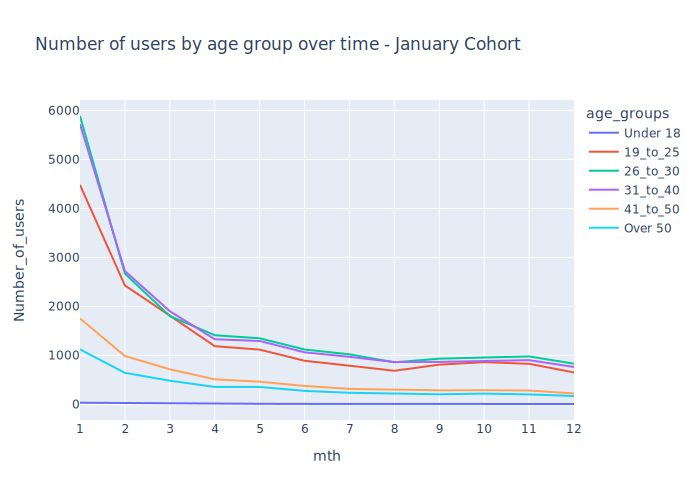

In [19]:
fig = px.line(df, x='mth', y='Number_of_users', color='age_groups', title = 'Number of users by age group over time - January Cohort')
fig.update_xaxes(dtick = 1)
fig.show(renderer="svg")

# Genre, purchase app type and venues

In [20]:
#need three inner joins on event_id

sql5 = """
select 
    t.user_id,
    t.event_id,
    t.purchase_app_type, 
    eg.genre,
    e.venue_country,
    e.venue_city,
    e.event_category
    
from analyst_task.transactions t 
    
inner join analyst_task.event_genres eg
    on eg.event_id = t.event_id
inner join analyst_task.events e
    on t.event_id = e.event_id

where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
"""
jan_info = pd.read_sql_query(text(sql5), engine)
jan_info.head()

,user_id,event_id,purchase_app_type,genre,venue_country,venue_city,event_category
0,62b6cf925fce5edecf95d6da78f1dca6,1fb4cb02bb3e373e9bc94f88d0dda37f,web_app,house,United States,Los Angeles,dj
1,62b6cf925fce5edecf95d6da78f1dca6,1fb4cb02bb3e373e9bc94f88d0dda37f,web_app,electronic,United States,Los Angeles,dj
2,bbeda56bbcfd8a9702bf2d3ba42ceb17,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,disco,France,Paris,party
3,bbeda56bbcfd8a9702bf2d3ba42ceb17,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,funk,France,Paris,party
4,bbeda56bbcfd8a9702bf2d3ba42ceb17,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,soul,France,Paris,party


In [21]:
purchase_type = jan_info.groupby(['purchase_app_type']).size()
df_type = purchase_type.to_frame()
df_type.rename(columns = {0:'Number_of_users'}, inplace = True)
df_type.reset_index(inplace = True)

df_type.head()

,purchase_app_type,Number_of_users
0,mobile_app,21020
1,web_app,27963


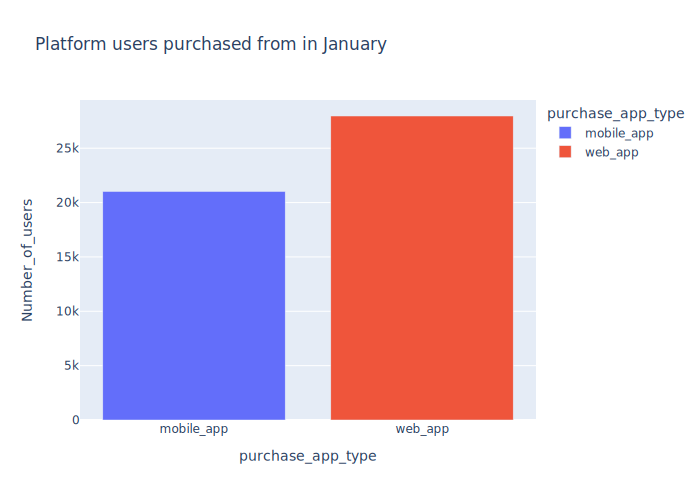

In [22]:
fig = px.bar(df_type, x='purchase_app_type', y='Number_of_users', color = 'purchase_app_type', title = 'Platform users purchased from in January')
fig.show(renderer="svg")

In [23]:
df_jan = pd.merge(jan_co,jan_info,on='user_id')
df_jan.head()

,user_id,yr,mth,num_engaged_users,num_interactions,event_id,purchase_app_type,genre,venue_country,venue_city,event_category
0,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,disco,France,Paris,party
1,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,funk,France,Paris,party
2,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,soul,France,Paris,party
3,038a75c9ebae7a00dd1f256890baab30,2019.0,1.0,1,2,7b0f98c9827941178ac24698c65a03d1,web_app,dance,United Kingdom,London,party
4,038a75c9ebae7a00dd1f256890baab30,2019.0,3.0,1,1,7b0f98c9827941178ac24698c65a03d1,web_app,dance,United Kingdom,London,party


In [24]:
grouped_app_type = df_jan.groupby(['mth', 'purchase_app_type']).size()
df_app_type = grouped_app_type.to_frame()
df_app_type.rename(columns = {0:'Number_of_users'}, inplace = True)
df_app_type.reset_index(level=['mth', 'purchase_app_type'], inplace = True)

grouped_country = df_jan.groupby(['mth', 'venue_country']).size()
df_country = grouped_country.to_frame()
df_country.rename(columns = {0:'Number_of_users'}, inplace = True)
df_country.reset_index(level=['mth', 'venue_country'], inplace = True)

grouped_genre = df_jan.groupby(['mth', 'genre']).size()
df_genre = grouped_genre.to_frame()
df_genre.rename(columns = {0:'Number_of_users'}, inplace = True)
df_genre.reset_index(level=['mth', 'genre'], inplace = True)

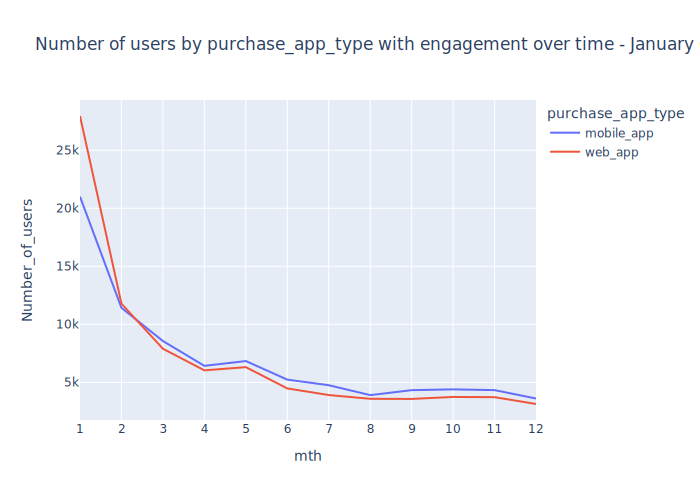

In [25]:
fig = px.line(df_app_type, x='mth', y='Number_of_users', color='purchase_app_type', title = 'Number of users by purchase_app_type with engagement over time - January Cohort')
fig.update_xaxes(dtick = 1)
fig.show(renderer="svg")

In [26]:
jan_info['venue_country'].unique().tolist()

['United States',
 'France',
 'United Kingdom',
 'Ireland',
 'Malta',
 '',
 'Germany']

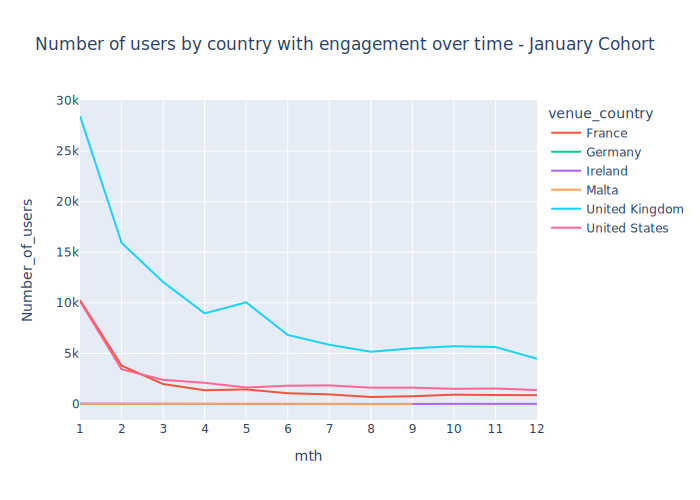

In [27]:
fig = px.line(df_country, x='mth', y='Number_of_users', color='venue_country', title = 'Number of users by country with engagement over time - January Cohort')
fig.update_xaxes(dtick = 1)
fig.show(renderer="svg")

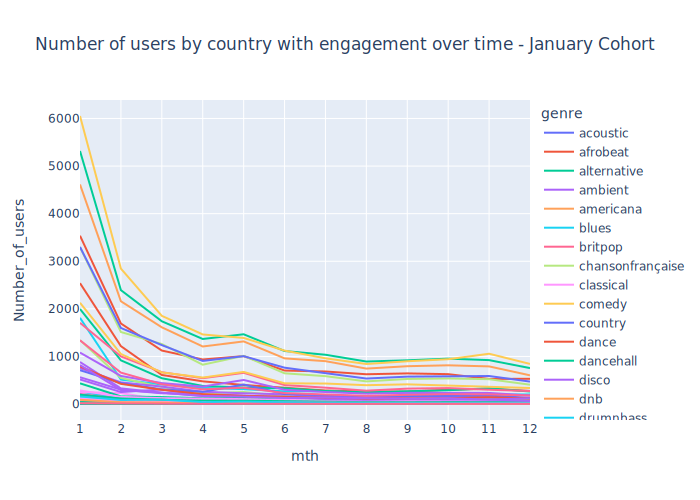

In [28]:
fig = px.line(df_genre, x='mth', y='Number_of_users', color='genre', title = 'Number of users by country with engagement over time - January Cohort')
fig.update_xaxes(dtick = 1)
fig.show(renderer="svg")

# Filter dataframe for the United Kingdom

In [29]:
jan_uk = df_jan[df_jan['venue_country'] == 'United Kingdom']
jan_uk

,user_id,yr,mth,num_engaged_users,num_interactions,event_id,purchase_app_type,genre,venue_country,venue_city,event_category
3,038a75c9ebae7a00dd1f256890baab30,2019.0,1.0,1,2,7b0f98c9827941178ac24698c65a03d1,web_app,dance,United Kingdom,London,party
4,038a75c9ebae7a00dd1f256890baab30,2019.0,3.0,1,1,7b0f98c9827941178ac24698c65a03d1,web_app,dance,United Kingdom,London,party
9,0313862e66816dd1673def211597ab81,2019.0,1.0,1,9,407db01dd77fdf631760f7c8599e0bd1,mobile_app,hiphop,United Kingdom,London,gig
10,0313862e66816dd1673def211597ab81,2019.0,1.0,1,9,407db01dd77fdf631760f7c8599e0bd1,mobile_app,rap,United Kingdom,London,gig
11,0313862e66816dd1673def211597ab81,2019.0,2.0,1,5,407db01dd77fdf631760f7c8599e0bd1,mobile_app,hiphop,United Kingdom,London,gig
...,...,...,...,...,...,...,...,...,...,...,...
170928,b34a8a72d576974d177a88f9fb1d4fca,2019.0,6.0,1,3,99576fbfb11e1807e500360cd29ed221,mobile_app,electronic,United Kingdom,London,gig
170929,b34a8a72d576974d177a88f9fb1d4fca,2019.0,6.0,1,3,99576fbfb11e1807e500360cd29ed221,mobile_app,hiphop,United Kingdom,London,gig
170930,b34a8a72d576974d177a88f9fb1d4fca,2019.0,6.0,1,3,99576fbfb11e1807e500360cd29ed221,mobile_app,dance,United Kingdom,London,gig
170931,b34a8a72d576974d177a88f9fb1d4fca,2019.0,6.0,1,3,99576fbfb11e1807e500360cd29ed221,mobile_app,pop,United Kingdom,London,gig


In [30]:
grouped_city = jan_uk.groupby(['mth', 'venue_city']).size()
df_uk_city = grouped_city.to_frame()
df_uk_city.rename(columns = {0:'Number_of_users'}, inplace = True)
df_uk_city.reset_index(level=['mth', 'venue_city'], inplace = True)

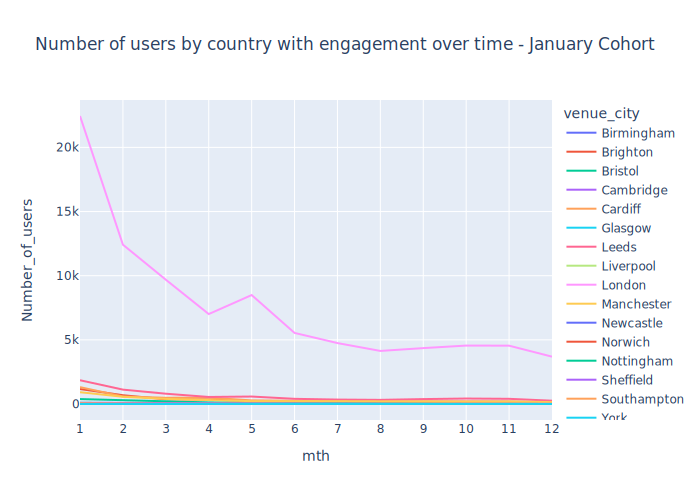

In [31]:
fig = px.line(df_uk_city, x='mth', y='Number_of_users', color='venue_city', title = 'Number of users by country with engagement over time - January Cohort')
fig.update_xaxes(dtick = 1)
fig.show(renderer="svg")

# Extensions:
More data:
- Create a cohort table for each month
- Create similar analysis for each month

More time:
- Create a correlation matrix between the retention percentage and other metrics using seaborn
- Drill down into specific segments i.e. genre + age_range + purchase_app_type
- Look at retention of users that joined a waiting list